In [ ]:
import os
import sagemaker

import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.seasonal import STL

from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Hydra

The `config` object is simply a dictionary of `config_key -> config_value`:

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='eda')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

### Data

To download the raw data from the Energy Information Administration website to the current working directory:

In [3]:
!wget -q {config['raw_data_url']} -O gas_data.xls

Read in the excel file:

In [4]:
gas_data = pd.read_excel(
    'gas_data.xls',
    sheet_name='Data 1',
    header=2, # The column names start on the 3rd row
    dtype={'Date': np.datetime64},
    index_col='Date'
)

gas_data.columns = ['gas_product']

gas_data.shape

(1710, 1)

Check for missing values and duplicate values:

In [5]:
assert gas_data['gas_product'].isna().sum() == 0
assert gas_data.index.duplicated(keep=False).sum() == 0

In this project, we will try to forecast the next 6 months of gas products, which means that the last $~6$ months (or $~26$ weeks) of data will become the test set. All EDA steps will be conducted on the training set. **Note:** the forecast horizon we choose here is arbitrary, and can be changed in the configuration file. 

In [6]:
train, test = pm.model_selection.train_test_split(gas_data, test_size=config['forecast_horizon'])
print(f'The training period is {train.index.min().strftime("%Y-%m-%d")} to {train.index.max().strftime("%Y-%m-%d")}')
print(f'The test period is {test.index.min().strftime("%Y-%m-%d")} to {test.index.max().strftime("%Y-%m-%d")}')

The training period is 1991-02-08 to 2023-05-12
The test period is 2023-05-19 to 2023-11-10


### Fundamental Questions in Time Series Analysis

To gain a comprehensive understanding of our time series data, we start by addressing two fundamental questions:

1. Is the time series stationary? From the book "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan (page 16):

    > To make statistical inferences about the structure of a stochastic process on the basis of an observed record of that process, we must usually make some simplifying (and presumably reasonable) assumptions about that structure. The most important such assumption is that of **stationarity**. The basic idea of stationarity is that the probability laws that govern the behavior of the process do not change over time. In a sense, the process is in statistical equilibrium. Specifically, a process ${Y_t}$ is said to be *strictly* stationary if the joint distribution of $Y_{t_1}, Y_{t_2},..., Y_{t_n}$ is the same as the joint distribution of $Y_{t_{1}– k}, Y_{t_{2}– k},..., Y_{t_a{n}– k}$ for all choices of time points $t_1, t_2,..., t_n$ and all choices of time lag k.

    In practice, we usually answer the question of stationarity using the *weak* definition. That is, a time series $Y_{t}$ is weakly stationary if 

    1. The mean function is constant over time
    2. $\gamma_{t, t-k}=\gamma_{0, k} \quad$ for all time $t$ and lag $k$

2. Is the time seires a white noise (i.e., a sequence of independent, identically distributed random variables)? The white noise is an example of a stationary process; most importantly, if the data is confirmed to be a white noise, we cannot reasonably forecast such time series. 

### Time Plot, ACF, & PACF

To answer the above questions, we rely on three essential plots:

1. **Time Plot**: this is simply the time series (y-axis) over time (x-axis). Things to look for in this plot are:

    - What is the baseline (grand mean) of the series over the sampling period?

    - Is there a trend (i.e. positive or negative slope) over time? 

    - Is there a noticeable (and consistent) seasonal pattern in the time series? There is a subtle difference between seasonal and any cyclical patterns; the latter do not have to be consistent. In other words, seasonal patterns (temperature fluctuation over the course of a single year) are predictable and cyclical (economic expansion, contraction, and trough) are not consistent in the long run. This is why it is important to examine the time plot of the series over time.

    - If there are repeated seasonal patterns, do the variances change over time? In other words, over time, do the vertical distances of the seasonal fluactuaions become larger or smaller? 

2. **ACF plot** or **correlogram**: the (sample) autocorrelation function, $r_{k}$, at lag $k$, for the observed time series $Y_1, Y_2, \ldots, Y_n$ is given as follows:

    \begin{equation*}
    r_k=\frac{\sum_{t=k+1}^n\left(Y_t-\bar{Y}\right)\left(Y_{t-k}-\bar{Y}\right)}{\sum_{t=1}^n\left(Y_t-\bar{Y}\right)^2} \quad \text{for } k=1,2, \ldots
    \end{equation*}
    
    where:

    * $Y_1, Y_2,..., Y_n$ is times series
    * $\bar{Y}$ is the grand mean of the entire series
    * $\sum_{t=1}^n\left(Y_t-\bar{Y}\right)^2$ is the grand sum of squares (i.e., there are $n$ squared terms)
    * $\sum_{t=k+1}^n\left(Y_t-\bar{Y}\right)\left(Y_{t-k}-\bar{Y}\right)$ is the sum of $n - k$ cross products

    Source: Equation adapted from "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan (page 46).

    In this plot, we are looking for significant correlation coefficients between the time series and different of lagged values of itself to determine if there are seasonal patterns or if the series is white noise.

    * If seasonal patterns are present, the plot of the sample ACF often exhibits [sinusoidal](https://en.wikipedia.org/wiki/Sine_wave) patterns.

    * If the time series is white noise, the correlogram displays statistically *insignificant* autocorrelation coefficients $r_{k}$ for most (if not all) lag $k$.

    * The ACF plot can often used to graphically determine the orders of the (non-seasonal) $MA(q)$ and (seasonal) $MA(Q)$ components of the (S)ARIMA model. It can be shown that, for $MA(q)$ and $MA(Q)$ processes, the autocorrelation function is theoretically zero for non-seasonal lags beyond $q$ or seasonal lags beyond $Q$. As a result, the sample ACF plot can be a good indicator for the $q$ or $Q$ at which the significant lags *cut off*.

3. **PACF plot**: the (sample) partial autocorrelation, denoted as $\phi_{k k}$, is defined as

    \begin{equation*}
    \phi_{k k}=\frac{\rho_k-\sum_{j=1}^{k-1} \phi_{k-1, j} \rho_{k-j}}{1-\sum_{j=1}^{k-1} \phi_{k-1, j} \rho_j}
    \end{equation*}
    
    where
    
    * $\phi_{k k}$ represents the correlation between $Y_t$ and $Y_{t − k}$ after removing the effect of the intermediate lag values ($Y_{t − 1}, Y_{t − 2}, Y_{t − 3},..., Y_{t − k + 1}$)
    
    * $\phi_{k, j}=\phi_{k-1, j}-\phi_{k k} \phi_{k-1, k-j} \quad \text { for } j=1,2, \ldots, k-1$

    Source: Equation adapted from "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan (page 115).

    The PACF at lag $k$ represents the correlation between $Y_t$ and $Y_{t − k}$ after removing the effect of the intermediate lag values ($Y_{t − 1}, Y_{t − 2}, Y_{t − 3},..., Y_{t − k + 1}$).
    
    The PACF has the same property for $AR$ processes as that of the ACF for $MA$ processes. Theoretically, the partial correlation coefficient at lag $k$ becomes zero beyond the the appropriate orders $p$ and $P$. Thus, the PACF plot is often used to identify the orders of the (non-seasonal) $AR(p)$ and (seasonal) $AR(P)$ components of the (S)ARIMA model.

<center>

Exhibit 6.3 General Behavior of the ACF and PACF for ARMA Models
| | AR \(p\) | MA \(q\) | ARMA \(p, q), p>0, and q>0\) |
|---|---|---|---|
| **ACF** | Tails off | Cuts off after lag \(q\) | Tails off |
| **PACF** | Cuts off after lag \(p\) | Tails off | Tails off |

Source: Time Series Analysis With Applications in R (page 116)

</center>

Although the table above describes the general behaviors for (non-seasonal) ARMA models, the same principles apply when determining the orders of the seasonal components $P$ and $Q$ for a (S)ARIMA model. However, instead of looking for characteristics like tailing off or cutting off beyond $p$ and $q$ lags, we focus on these characteristics over seasonal lags. For weekly data, where the seasonality period is approximately $365.25/7 \approx 52.18$, we can pay attention to lag 52, 104, and so on. 

In terms of the number of lags to plot, we use a rule-of-thumb based on the following [post](https://robjhyndman.com/hyndsight/ljung-box-test/) by [Rob Hyndman](https://robjhyndman.com/).

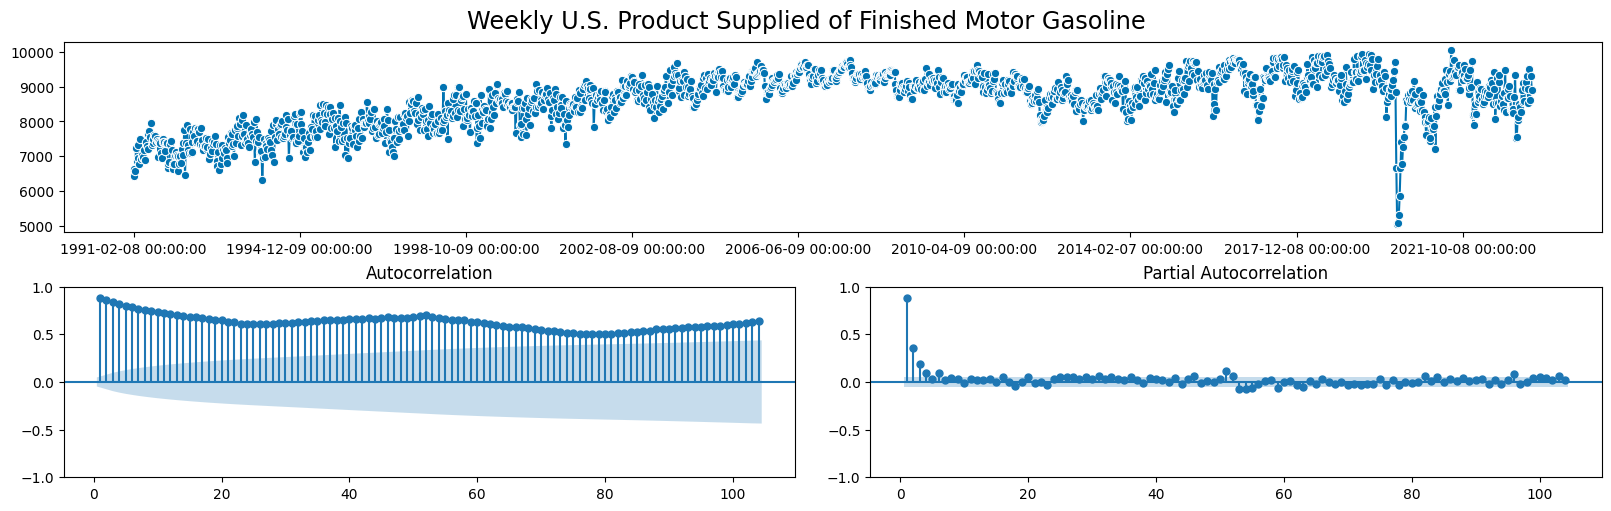

In [7]:
lags = np.min([2 * (365.25 / 7), (train.shape[0] / 5)])

fig, ax = plot_correlations(
    series=train,
    lags=lags,
    zero_lag=False,
    suptitle='Weekly U.S. Product Supplied of Finished Motor Gasoline'
)
fig.set_size_inches((16, 5))
plt.show()

#### ACF

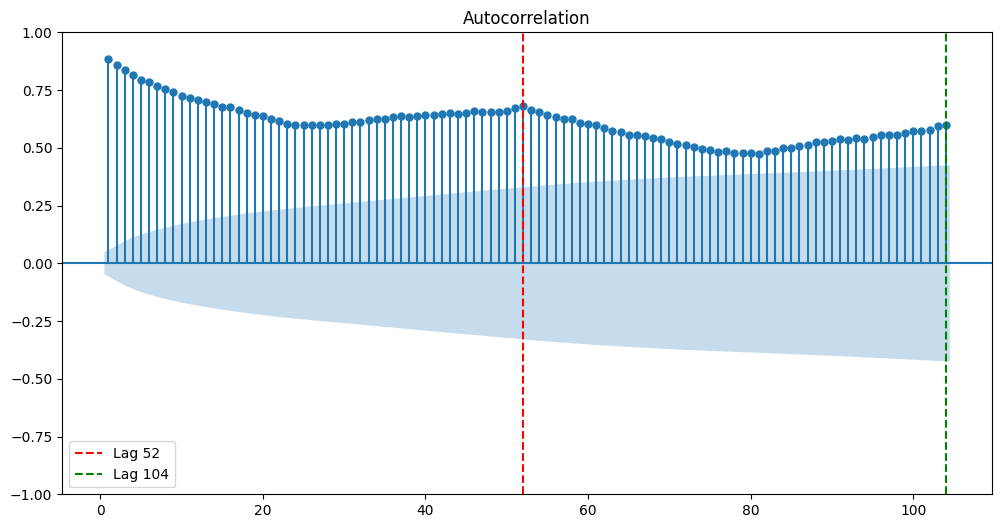

In [8]:
fig = plot_acf(
    x=train, 
    lags=lags,
    zero=False
)
fig.set_size_inches(12, 6)
plt.axvline(x=52, color='r', linestyle='--', label='Lag 52')
plt.axvline(x=104, color='g', linestyle='--', label='Lag 104')
plt.legend()
plt.show();

#### PACF

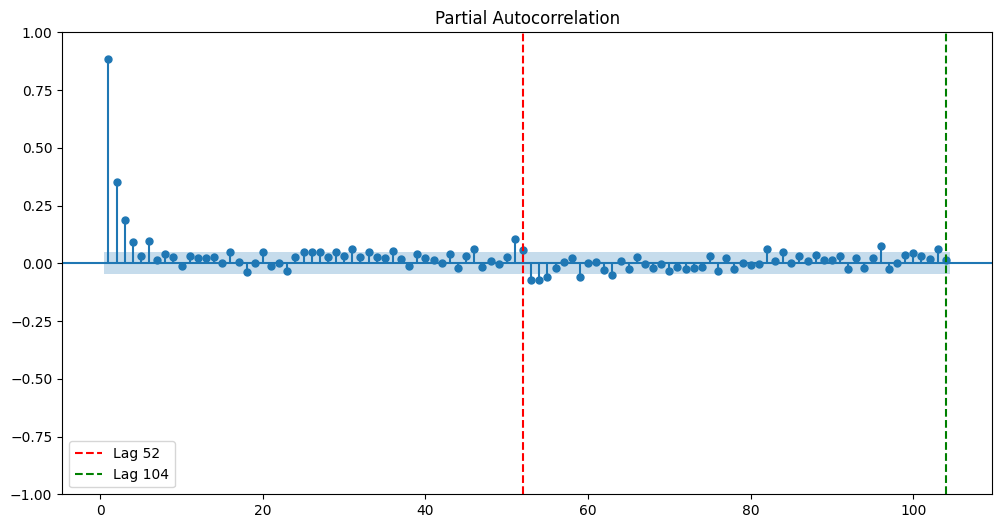

In [9]:
fig = plot_pacf(
    x=train, 
    lags=lags,
    zero=False
)
fig.set_size_inches(12, 6)
plt.axvline(x=52, color='r', linestyle='--', label='Lag 52')
plt.axvline(x=104, color='g', linestyle='--', label='Lag 104')
plt.legend()
plt.show();

#### Observations

The following observations can be made:

1. The time series is definitely non-stationary with both weekly seasonality and non-constant trends, as indicated by the sinusoidal patterns in the ACF (i.e., the peak-to-peak patterns last about $~52$ lags).

2. The trends can be more clearly observed by plotting the yearly averages:

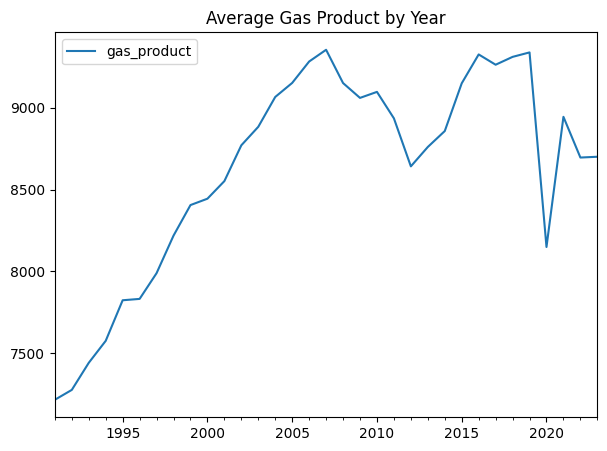

In [10]:
train.resample('YS').mean().plot(y='gas_product', figsize=(7, 5), title='Average Gas Product by Year');

3. The yearly variances of the series, with the exception of year 2020 (i.e., COVID-19), appear relatively stable, but we can further stabilize the variances with a data transformation.

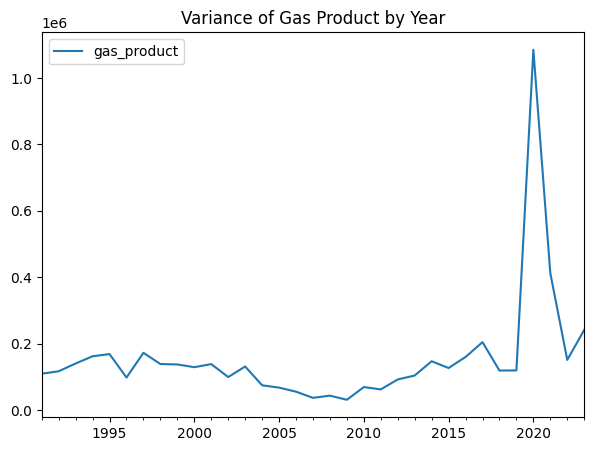

In [11]:
train.resample('YS').var().plot(y='gas_product', figsize=(7, 5), title='Variance of Gas Product by Year');


4. The confirmed seasonal period is quite long, i.e., $m\approx52.18$. Instead of the (S)ARIMA model, which is designed for shorter seasonal periods such as 12 for monthly data and 4 for quarterly data, we can train a harmonic regression model. With this approach,

    \begin{equation*}
    y_t=a+\sum_{k=1}^K\left[\alpha_k \sin (\frac{2 \pi k t}{m})+\beta_k \cos (\frac{2 \pi k t}{m})\right]+N_t
    \end{equation*}

    - seasonal patterns are modeled using [Fourier terms](https://robjhyndman.com/hyndsight/longseasonality/) 

    - short-term patterns are modeled by the $N_{t}$ ARMA process

    - the smoothness of the seasonal pattern can be controlled by the frequency hyperparameter $K$, which is the number of Fourier sin and cos pairs; the seasonal pattern is smoother for smaller values of $K$, which can be tuned using time-series cross-validation

5. Finally, the devastating effect of the COVID-19 pandemic on the gasoline industry is fairly noticeable in the time plot for year 2020. These extreme values should be addressed before training any model. There may be many possible ways to handle these outliers, but we will revert to an approach of [judgemental](https://otexts.com/fpp3/judgmental.html) forecasting.

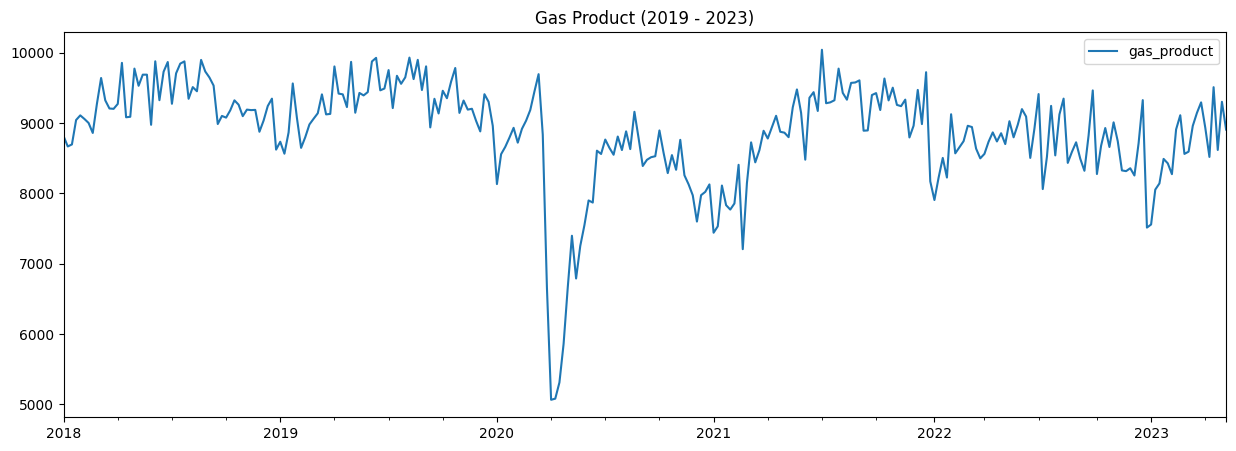

In [12]:
train.loc['2018':'2023'].plot(figsize=(15, 5), title='Gas Product (2019 - 2023)');

### Handling COVID-19 with Scenario-Based Forecasting

It can be argued that the sudden drop of gasoline products observed in the data (and in the time plot) represents a [structural break](https://en.wikipedia.org/wiki/Structural_break) that is caused by the COVID-19 pandemic. According to the research conducted by Athanasopoulos et al. (2023) and published in the Journal of Travel Research, Volume 62, Issue 1, the biggest challenge presented by the COVID-19 pandemic on any forecasting tasks is an increased level of uncertainly:

> From a statistical modelling and forecasting perspective, these disruptions cause unique challenges. The pandemic has meant that we cannot extrapolate the strong and persistent signals observed in historical tourism time series. The structural break is deep and the path to recovery remains extremely uncertain. 

The authors in this paper argue that historical data from the COVID-19 years cannot be used to forecast without first addressing this structural breakdown:   

> ... the effect of the COVID-19 pandemic is such that historical data cannot be used to project forward without explicitly accounting for the depth and the length of the structural break caused by COVID-19, and the subsequent unknown and unprecedented path to recovery. Both the depth and length of the effect of the pandemic are extremely challenging or even impossible to estimate and predict statistically, and therefore we revert to a novel approach of judgemental forecasting.

In this project, we will develop our own judgmental forecasting methodology, which includes the following steps:

- Identify outliers using robust Season-Trend decomposition with LOESS weighting, where any outliers will be detected in the remainder series.
- Determine the outlier with the earliest and latest dates within the COVID-19 years (i.e., Jan 2020 onward). These effectively serve as proxies for the length of the structural break.
- Utilize STL forecasting, which employs the [seasonal naive method](https://otexts.com/fpp3/simple-methods.html#seasonal-na%C3%AFve-method) for forecasting the decomposed trend, seasonal, and residual components separately; these forecasts are then combined to predict gasoline product for all observations between the dates identified in the previous step.
- Replace all values between the earliest and latest dates within the COVID-19 years with the forecast generated by the model. 

This approach allows us to consider a counterfactual scenario had the COVID-19 pandemic never occurred. Any subsequent models trained on this "counterfactual" data generate forecasts that can be regarded as recovery trajectories. In other words, these forecasts represent the gasoline production levels that might have been attained if the pandemic had not happened, and they should serve as the benchmark that producers should aim to return to.

The objective is to provide more dependable scenario-based forecasts. Consequently, the step involving the training of a model to predict the COVID-19 data will be treated as a hyperparameter in itself, fine-tuned using time series cross-validation.

#### Decomposition

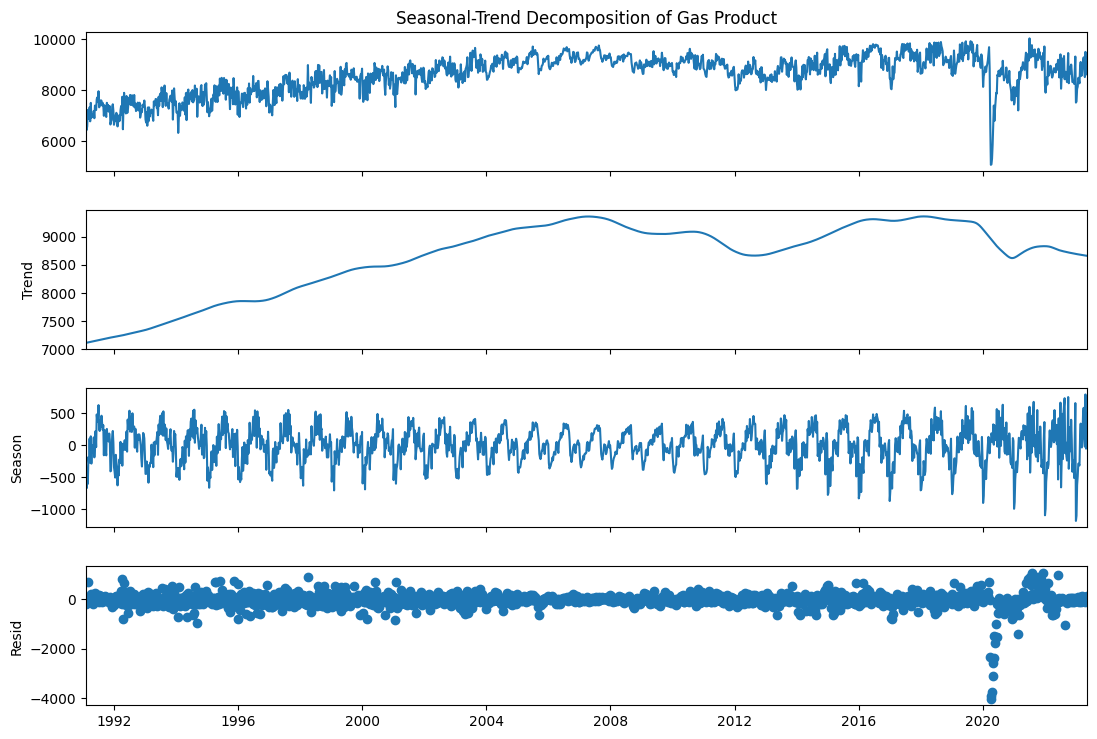

In [13]:
m = (365.25 / 7)
decomp_result = STL(endog=pd.Series(train['gas_product'], name='Seasonal-Trend Decomposition of Gas Product'), period=int(np.floor(m)), robust=True).fit()
fig = decomp_result.plot()
fig.set_size_inches(12, 8)
plt.show();

#### Outlier Detection

We define outliers as observations whose residuals are greater than three times the interquartile range (IQRs) of the middle 50% of the data. 

In [14]:
resid_75 = np.quantile(decomp_result._resid, 0.75)
resid_25 = np.quantile(decomp_result._resid, 0.25)
resid_iqr = resid_75 - resid_25

# Indices of outliers
outlier_indices = np.logical_or((decomp_result._resid > resid_75 + 3 * resid_iqr), (decomp_result._resid < resid_25 - 3 * resid_iqr))
outlier_indices.sum()

45

Print the earliest and latest dates of the outliers within the COVID-19 years:

In [15]:
earliest = train.loc[(outlier_indices)].loc['2020'].index.min().strftime('%Y-%m-%d')
latest = train.loc[(outlier_indices)].index.max().strftime('%Y-%m-%d')
print(f'The outlier with the earliest date within the COVID-19 years is {earliest}')
print(f'The outlier with the latest date within the COVID-19 years is {latest}')

The outlier with the earliest date within the COVID-19 years is 2020-03-13
The outlier with the latest date within the COVID-19 years is 2022-08-19


We will add a boolean column to the data set to flag outlying observations that should be substituted with forecasts: 

In [16]:
train['covid_forecast'] = np.logical_and((train.index >= earliest), (train.index <= latest))
test['covid_forecast'] = False

### Upload to S3

We can proceed by uploading the raw data, including the new boolean column, to S3. This step is crucial as it enables us to continue with the following tasks:

- Train-test split

- Forecasting COVID-19 data using historical data

We will perform these tasks using a SageMaker processing job.

In [ ]:
# Save the outlier indices to the current directory
pd.concat([train, test], axis=0).to_csv('gas_data.csv', index=True)

# Upload both the raw data and the outlier indices to s3
sagemaker.s3.S3Uploader.upload('gas_data.csv', f's3://{config["s3_bucket"]}/{config["s3_key"]}/raw-data')

# Remove from the current directory
os.remove('gas_data.csv')
os.remove('gas_data.xls')